In [1]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# TOKEN = user_secrets.get_secret("GITHUB_TOKEN")
#
# !git clone https://{TOKEN}@github.com/nicoloalbergoni/DeeplabV3Plus-TF2.git
# %load_ext tensorboard
# %cd ./DeeplabV3Plus-TF2

In [2]:
#!python download_and_prepare_voc.py --remove_cmap --download_berkley

In [3]:
import os
import random
import h5py
import numpy as np
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from model import DeeplabV3Plus
import tensorflow_addons as tfa
from matplotlib import pyplot as plt
from superresolution_scripts.superresolution import Superresolution
from utils import load_image, get_prediction, create_mask, plot_prediction
from superresolution_scripts.superres_utils import get_img_paths, filter_by_class, min_max_normalization, plot_image, plot_histogram, list_precomputed_data_paths, check_hdf5_validity, threshold_image, single_class_IOU

In [4]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
PASCAL_ROOT = os.path.join(DATA_DIR, "dataset_root", "VOCdevkit", "VOC2012")
IMGS_PATH = os.path.join(PASCAL_ROOT, "JPEGImages")

SUPERRES_ROOT = os.path.join(DATA_DIR, "superres_root")
PRECOMPUTED_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "precomputed_features")
STANDARD_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "standard_output")
SUPERRES_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "superres_output")

# SEED = np.random.randint(0, 1000)
SEED = 1234
IMG_SIZE = (512, 512)
BATCH_SIZE = 2
BUFFER_SIZE = 1000
EPOCHS = 30
CLASSES = 21
RESHAPE_MASKS = True
NUM_AUG = 50
CLASS_ID = 8
NUM_SAMPLES = 300
MODE = "slice"

In [5]:
image_list_path = os.path.join(DATA_DIR, "augmented_file_lists", "valaug.txt")
image_paths = get_img_paths(image_list_path, IMGS_PATH)

if NUM_SAMPLES is not None:
    image_paths = image_paths[:NUM_SAMPLES]

images_dict = filter_by_class(image_paths, class_id=CLASS_ID)

print(f"Valid images: {len(images_dict)} (Initial:  {len(image_paths)})")

valid_filenames = list(images_dict.keys())

model_no_upsample = DeeplabV3Plus(
    input_shape=(512, 512, 3),
    classes=21,
    OS=16,
    last_activation=None,
    load_weights=True,
    backbone="mobilenet",
    alpha=1.).build_model(final_upsample=False)

model_standard = DeeplabV3Plus(
    input_shape=(512, 512, 3),
    classes=21,
    OS=16,
    last_activation=None,
    load_weights=True,
    backbone="mobilenet",
    alpha=1.).build_model(final_upsample=True)

Valid images: 26 (Initial:  300)


# Compute standard output for comparison

In [6]:
def compute_standard_output(image_dict, model, dest_folder, filter_class_id=None):
    standard_masks = {}
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for key in tqdm(image_dict):
        standard_mask = get_prediction(model, image_dict[key])
        if filter_class_id is not None:
            standard_mask = tf.where(standard_mask == filter_class_id, standard_mask, 0) # Set to 0 all predictions different from the given class
        tf.keras.utils.save_img(f"{dest_folder}/{key}.png", standard_mask, scale=False)
        standard_masks[key] = standard_mask

    return standard_masks

In [7]:
standard_masks_dict = compute_standard_output(images_dict, model_standard, dest_folder=STANDARD_OUTPUT_DIR, filter_class_id=CLASS_ID)

100%|██████████| 26/26 [00:07<00:00,  3.66it/s]


# Precompute Augmented Output Features

In [8]:
def create_augmented_copies(image, num_aug, angle_max, shift_max):

    batched_images = tf.tile(tf.expand_dims(image, axis=0), [num_aug, 1, 1, 1])  # Size [num_aug, 512, 512, 3]
    angles = np.random.uniform(-angle_max, angle_max, num_aug)
    shifts = np.random.uniform(-shift_max, shift_max, (num_aug, 2))
    # First sample is not augmented
    angles[0] = 0
    shifts[0] = np.array([0, 0])
    angles = angles.astype("float32")
    shifts = shifts.astype("float32")

    rotated_images = tfa.image.rotate(batched_images, angles, interpolation="bilinear")
    translated_images = tfa.image.translate(rotated_images, shifts, interpolation="bilinear")

    return translated_images, angles, shifts

def compute_augmented_features(image_filenames, model, dest_folder, filter_class_id, mode="slice", num_aug=100, angle_max=0.5, shift_max=30, save_output=False, relu_output=False):

    augmented_features = {}

    for filename in tqdm(image_filenames):

        # Load image
        image_path = os.path.join(IMGS_PATH, f"{filename}.jpg")
        image = load_image(image_path, image_size=IMG_SIZE, normalize=True)

        # Create augmented copies
        augmented_images, angles, shifts = create_augmented_copies(image, num_aug=num_aug, angle_max=angle_max, shift_max=shift_max)

        # Create destination folder
        output_folder = os.path.join(dest_folder, filename)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Get model prediction for each aumented copy
        predictions = model.predict(augmented_images, batch_size=BATCH_SIZE)

        class_masks = []
        max_masks = []

        for i, prediction in enumerate(predictions):

            if mode == "slice":
                class_slice = prediction[:, :, filter_class_id]
                class_mask = class_slice[..., np.newaxis]

                no_class_prediction = np.delete(prediction, filter_class_id, axis=-1)
                max_mask = no_class_prediction.max(axis=-1)
                max_mask = max_mask[..., np.newaxis]

                # ReLU is only needed when working with slices
                if relu_output:
                    class_mask = (tf.nn.relu(class_mask)).numpy()
                    max_mask = (tf.nn.relu(max_mask)).numpy()

                max_masks.append(max_mask)

            elif mode == "argmax":
                class_mask = create_mask(prediction)
                # Set to 0 all predictions different from the given class
                class_mask = tf.where(class_mask == filter_class_id, class_mask, 0)
                class_mask = tf.cast(class_mask, tf.float32) # Necessary for super-resolution operations
                class_mask = class_mask.numpy()

            class_masks.append(class_mask)

            if save_output:
                tf.keras.utils.save_img(f"{output_folder}/{i}_class.png", class_mask, scale=True)
                if mode == "slice":
                    tf.keras.utils.save_img(f"{output_folder}/{i}_max.png", max_mask, scale=True)

            # np.save(os.path.join(output_folder, f"{filename}_angles"), angles)
            # np.save(os.path.join(output_folder, f"{filename}_shifts"), shifts)

        file = h5py.File(f"{output_folder}/{filename}.hdf5", "w")
        file.create_dataset("class_masks", data=class_masks)

        if mode == "slice":
            file.create_dataset("max_masks", data=max_masks)

        file.create_dataset("angles", data=angles)
        file.create_dataset("shifts", data=shifts)
        file.attrs["filename"] = filename
        file.attrs["mode"] = mode

        file.close()

        augmented_features[filename] = { "class": class_masks, "max": max_masks }

    return augmented_features

In [9]:
angle_max = 0.5  # in radians
shift_max = 30

augmented_features_dict = compute_augmented_features(images_dict, model_no_upsample, mode=MODE, dest_folder=PRECOMPUTED_OUTPUT_DIR, filter_class_id=CLASS_ID, num_aug=NUM_AUG, angle_max=angle_max, shift_max=shift_max, save_output=False, relu_output=False)

100%|██████████| 26/26 [01:34<00:00,  3.62s/it]


# Compute Super-Resolution Output

In [10]:
def compute_superresolution_output(precomputed_data_paths, superresolution_obj, dest_folder, mode="slice", num_aug=100, global_normalize=True, save_output=False):

    superres_masks = {}
    losses = {}

    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for file_path in tqdm(precomputed_data_paths):

        file = h5py.File(f"{file_path}", "r")

        if not check_hdf5_validity(file, num_aug=num_aug):
            print(f"File: {file_path} is invalid, skipping...")
            file.close()
            continue


        filename = file.attrs["filename"]
        angles = file["angles"][:]
        shifts = file["shifts"][:]

        class_masks = file["class_masks"][:]
        class_masks = tf.stack(class_masks)

        if mode == "slice":
            max_masks = file["max_masks"][:]
            max_masks = tf.stack(max_masks)

        file.close()

        global_min = tf.reduce_min(class_masks) if global_normalize else None
        global_max = tf.reduce_max(class_masks) if global_normalize else None

        class_masks = tf.map_fn(fn=lambda image: min_max_normalization(image.numpy(), new_min=0.0, new_max=1.0, global_min=global_min, global_max=global_max), elems=class_masks)

        target_image_class, class_loss = superresolution_obj.compute_output(class_masks, angles, shifts)
        target_image_class = (target_image_class[0]).numpy()
        # print(f"Final class loss for image {filename}: {class_loss}")

        if mode == "slice":

            global_min = tf.reduce_min(max_masks) if global_normalize else None
            global_max = tf.reduce_max(max_masks) if global_normalize else None

            max_masks = tf.map_fn(fn=lambda image: min_max_normalization(image.numpy(), new_min=0.0, new_max=1.0, global_min=global_min, global_max=global_max), elems=max_masks)


            target_image_max, max_loss = superresolution_obj.compute_output(max_masks, angles, shifts)
            target_image_max = (target_image_max[0]).numpy()
            # print(f"Final max loss for image {filename}: {max_loss}")


        if save_output:
            tf.keras.utils.save_img(f"{dest_folder}/{filename}_class.png", target_image_class, scale=True)
            if mode == "slice":
                tf.keras.utils.save_img(f"{dest_folder}/{filename}_max.png", target_image_max, scale=True)


        superres_masks[filename] = { "class": target_image_class, "max": target_image_max } if mode == "slice" else target_image_class

    return superres_masks, losses



In [11]:
# super resolution parameters
# learning_rate = 1e-3
# lambda_eng = 0.0001 * NUM_AUG
# lambda_tv = 0.002 * NUM_AUG
# num_iter = 400

learning_rate = 1e-3
lambda_eng = 0.10102
lambda_tv = 0.42462
num_iter = 400

superresolution = Superresolution(
    lambda_tv=lambda_tv,
    lambda_eng=lambda_eng,
    num_iter=num_iter,
    num_aug=NUM_AUG,
    learning_rate=learning_rate,
    verbose=False
)

precomputed_data_paths = list_precomputed_data_paths(PRECOMPUTED_OUTPUT_DIR)

superres_masks_dict, losses = compute_superresolution_output(precomputed_data_paths, superresolution, mode=MODE, dest_folder=SUPERRES_OUTPUT_DIR, num_aug=NUM_AUG, global_normalize=True, save_output=True)

100%|██████████| 26/26 [15:05<00:00, 34.82s/it]


In [12]:
superres_masks_dict_th = {}

for key in superres_masks_dict:
    target_dict = superres_masks_dict[key]
    if MODE == "slice":
        th_mask = threshold_image(target_dict["class"], CLASS_ID, th_mask=target_dict["max"])
    else:
        th_mask = threshold_image(target_dict["class"], CLASS_ID, th_factor=.15)

    superres_masks_dict_th[key] = th_mask.numpy()

# Evaluation

In [13]:
def evaluate_IOU(true_mask, standard_mask, superres_mask, img_size=(512, 512)):
    true_mask = tf.reshape(true_mask, (img_size[0] * img_size[1], 1))
    standard_mask = tf.reshape(standard_mask, (img_size[0] * img_size[1], 1))
    superres_mask = tf.reshape(superres_mask, (img_size[0] * img_size[1], 1))

    # standard_IOU = Mean_IOU(true_mask, standard_mask)
    # superres_IOU = Mean_IOU(true_mask, superres_mask)

    standard_IOU = single_class_IOU(true_mask, standard_mask, class_id=CLASS_ID)
    superres_IOU = single_class_IOU(true_mask, superres_mask, class_id=CLASS_ID)

    return standard_IOU.numpy(), superres_IOU.numpy()

def compare_results(image_dict, standard_dict, superres_dict, image_size=(512, 512), verbose=False):
    standard_IOUs = []
    superres_IOUs = []

    for key in image_dict:
        true_mask_path = os.path.join(PASCAL_ROOT, "SegmentationClassAug", f"{key}.png")
        true_mask = load_image(true_mask_path, image_size=image_size, normalize=False,
                               is_png=True, resize_method="nearest")

        standard_mask = standard_dict[key]
        superres_image = superres_dict[key]

        standard_IOU, superres_IOU = evaluate_IOU(true_mask, standard_mask, superres_image, img_size=image_size)
        standard_IOUs.append(standard_IOU)
        superres_IOUs.append(superres_IOU)

        if verbose:
            print(f"IOUs for image {key} - Standard: {str(standard_IOU)}, Superres: {str(superres_IOU)}")

    return standard_IOUs, superres_IOUs

In [14]:
standard_IOUs, superres_IOUs = compare_results(images_dict, standard_masks_dict, superres_masks_dict_th, image_size=IMG_SIZE, verbose=False)

In [15]:
print(f"Standard mean IOU: {np.mean(standard_IOUs)},  Superres mean IOU: {np.mean(superres_IOUs)}")

Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.7966035003414785


# Tests

In [16]:
def plot_standard_superres(input_image, ground_truth, standard_mask, superres_mask):
    plt.figure(figsize=(18, 18))

    plt.subplot(1, 3, 1)
    plt.title("Ground Truth")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(ground_truth), alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Sandard predicted Mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(standard_mask), alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Superresolution Mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(superres_mask), alpha=0.5)
    plt.axis('off')


    plt.show()

In [17]:
sample_key = random.choice(valid_filenames)
sample_image = images_dict[sample_key]
sample_standard = standard_masks_dict[sample_key]
sample_superres = superres_masks_dict[sample_key]["class"]
sample_superres_th = superres_masks_dict_th[sample_key]

true_mask_path = os.path.join(PASCAL_ROOT, "SegmentationClassAug", f"{sample_key}.png")
true_mask = load_image(true_mask_path, image_size=IMG_SIZE, normalize=False, is_png=True, resize_method="nearest")

#plot_prediction([sample_image, true_mask, sample_standard], only_prediction=False, show_overlay=True)
#print_labels([true_mask, sample_standard])

In [18]:
#plot_image(sample_superres_th)

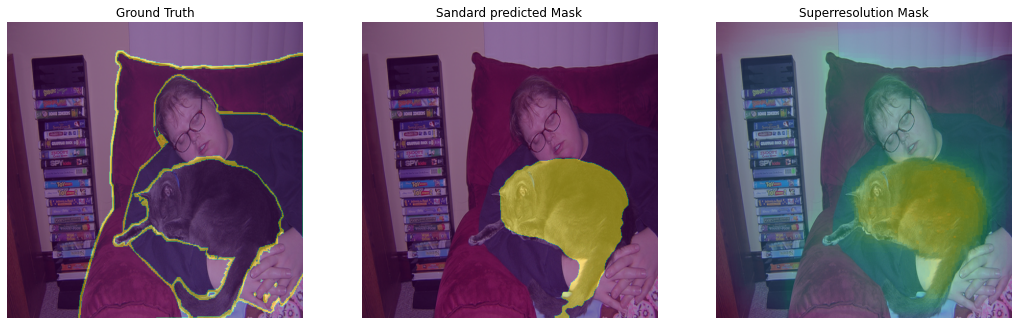

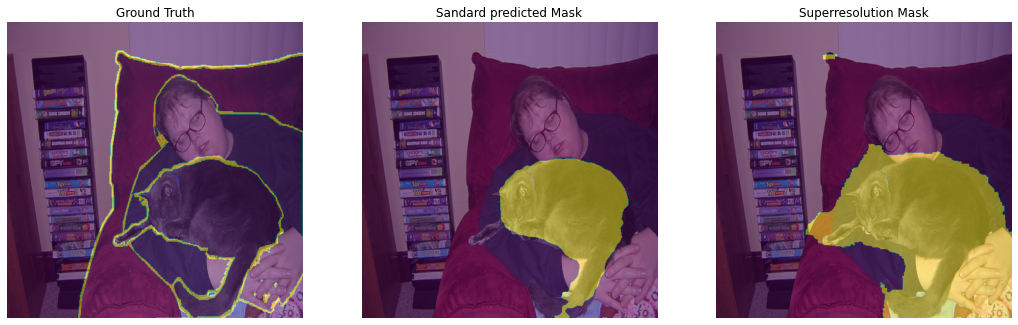

(0.8811572294175283, 0.674003160929208)

In [19]:
plot_standard_superres(sample_image, true_mask, sample_standard, sample_superres)
plot_standard_superres(sample_image, true_mask, sample_standard, sample_superres_th)
evaluate_IOU(true_mask, sample_standard, sample_superres_th)

In [20]:
th_ranges = np.arange(0.50, 1.0, 0.05)
results = {}

for th_value in th_ranges:
    superres_masks_dict_th_test = {}
    for key in superres_masks_dict:
        target_dict = superres_masks_dict[key]
        target_mask = target_dict["class"]

        th_mask_value = tf.cast(tf.reduce_max(target_mask), tf.float32) * th_value
        th_mask = tf.where(target_mask > th_mask_value, CLASS_ID, 0)
        superres_masks_dict_th_test[key] = th_mask.numpy()

    standard_IOUs, superres_IOUs = compare_results(images_dict, standard_masks_dict, superres_masks_dict_th_test, image_size=IMG_SIZE, verbose=False)

    mean_standard_IOUs = np.mean(standard_IOUs)
    mean_superres_IOUs = np.mean(superres_IOUs)
    results[th_value] = (mean_standard_IOUs, mean_superres_IOUs)
    print(f"Threshold Value: {th_value} -- Standard mean IOU: {np.mean(standard_IOUs)},  Superres mean IOU: {np.mean(superres_IOUs)}")

Threshold Value: 0.5 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.630790639248737
Threshold Value: 0.55 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.7051001479688602
Threshold Value: 0.6000000000000001 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.7716518992615745
Threshold Value: 0.6500000000000001 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.8052031023903207
Threshold Value: 0.7000000000000002 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.8111425759255914
Threshold Value: 0.7500000000000002 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.7957114782034561
Threshold Value: 0.8000000000000003 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.7492637098155236
Threshold Value: 0.8500000000000003 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.654995831199401
Threshold Value: 0.9000000000000004 -- Standard mean IOU: 0.8432970924901599,  Superres mean IO